In [29]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Class weight calculation
from sklearn.utils.class_weight import compute_class_weight

# Keras library
from keras.models import Sequential
from keras.layers import  Dense, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

# Different CNN Model
from keras.applications import VGG16, InceptionV3, MobileNetV2, DenseNet121

# To chain two different data augmented images for training
#from itertools import chain

#  Distributed Computing
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [30]:
BATCH_SIZE = 48

image_height = 299
image_width = 299

# Data agumentation and pre-processing using tensorflow
data_generator_1 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=5,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            brightness_range = [0.95,1.05],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'
                        )

print('Data Augmentation 1 was created')

data_generator_2 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            brightness_range = [0.9,1.1],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'
                        )
print('Data Augmentation 2 was created')

Data Augmentation 1 was created
Data Augmentation 2 was created


In [31]:
data_generator_3 = ImageDataGenerator(rescale=1./255)

train_generator1 = data_generator_1.flow_from_directory(
    directory=r"C:\Users\PC\OneDrive\Desktop\pneumonia_detection\xray or not\XRAY OR NOT\train",
    color_mode="rgb",
    target_size=(image_height, image_width),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

print('Data Augmentation 1 was used to generate the train data set\n')

test_generator = data_generator_3.flow_from_directory(
    directory=r"C:\Users\PC\OneDrive\Desktop\pneumonia_detection\xray or not\XRAY OR NOT\test",
    color_mode="rgb",
    target_size=(image_height, image_width),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

Found 10617 images belonging to 2 classes.
Data Augmentation 1 was used to generate the train data set

Found 600 images belonging to 2 classes.


In [32]:
dict_class = train_generator1.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())  # storing class/breed names in a list
print('Class labels: {}'.format(class_names))

Dictionary: {'Not X-Ray': 0, 'X-Ray': 1}
Class labels: ['Not X-Ray', 'X-Ray']


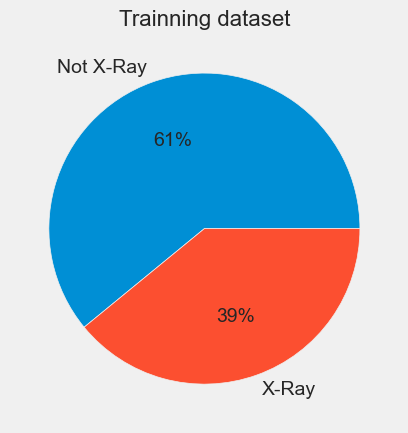

In [35]:
frequency = np.unique(train_generator1.classes, return_counts=True)

plt.title("Trainning dataset", fontsize='16')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');

In [37]:
# Dataset characteristics
print("Dataset Characteristics of Train Data Set:")
print("Number of images:", len(train_generator1.classes))
print("Number of Not X-Ray images:", len([label for label in train_generator1.classes if label == 0]))
print("Number of X-Ray images:", len([label for label in train_generator1.classes if label == 1]))
print()

print("Dataset Characteristics of Test Data Set:")
print("Number of images:", len(test_generator.classes))
print("Number of Not X Ray images:", len([label for label in test_generator.classes if label == 0]))
print("Number of X Ray images:", len([label for label in test_generator.classes if label == 1]))
print()

Dataset Characteristics of Train Data Set:
Number of images: 10617
Number of Not X-Ray images: 6469
Number of X-Ray images: 4148

Dataset Characteristics of Test Data Set:
Number of images: 600
Number of Not X Ray images: 300
Number of X Ray images: 300



In [38]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator1.classes), y= train_generator1.classes)
class_weights = dict(zip(np.unique(train_generator1.classes), class_weights))
class_weights

{0: 0.8206059669191529, 1: 1.2797733847637416}

Train image data from Data Augmentation 1


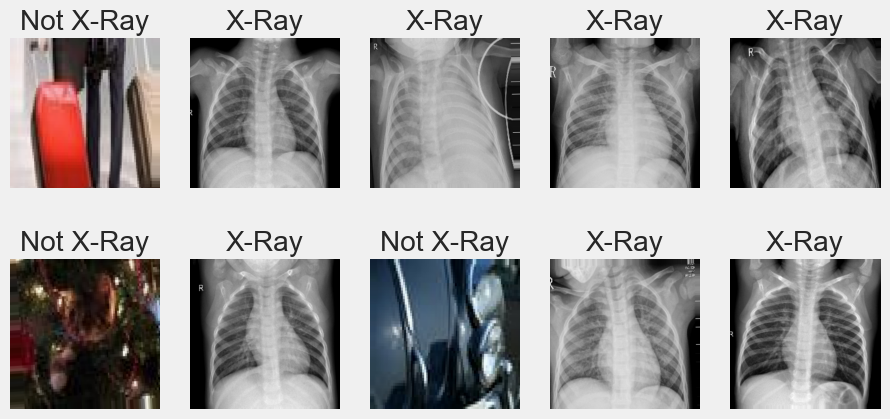

In [39]:
print('Train image data from Data Augmentation 1')
img, label = next(train_generator1)
# print(len(label))

plt.figure(figsize=[10, 5])
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])
plt.show()

In [40]:
# Define the epochs for training
EPOCHS = 2

# Define the number of GPUs to use
num_gpus = 2

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.001, patience=10, verbose=1)

train_data = train_generator1


In [42]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():

    # Load the pre-trained VGG16 model without the top classification layer
    base_model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Set the layers of the base model as non-trainable (freeze them)
    for layer in base_model_VGG16.layers:
        layer.trainable = False

    # Create a new model and add the VGG16 base model
    model_VGG16 = Sequential()
    model_VGG16.add(base_model_VGG16)

    # Add a fully connected layer and output layer for classification
    model_VGG16.add(GlobalAveragePooling2D())
    model_VGG16.add(Dense(128, activation='relu'))
    model_VGG16.add(Dropout(0.4))
    model_VGG16.add(Dense(64, activation='relu'))
    model_VGG16.add(Dropout(0.2))
    model_VGG16.add(Dense(2, activation='softmax'))


    # Model summary
    print("Model Summary (VGG16):")
    model_VGG16.summary()
    print()

    # Compile the model
    model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history_VGG16 = model_VGG16.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

    # Validate the model
    val_loss_VGG16, val_accuracy_VGG16 = model_VGG16.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_VGG16:.4f}')
    print(f'Validation Accuracy: {val_accuracy_VGG16:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model Summary (VGG16):
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                             

In [43]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():

    # Load the pre-trained MobileNetV2 model without the top classification layer
    base_model_MobileNet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Set the layers of the base model as non-trainable (freeze them)
    for layer in base_model_MobileNet.layers:
        layer.trainable = False

    # Create a new model and add the MobileNetV2 base model
    model_MobileNet = Sequential()
    model_MobileNet.add(base_model_MobileNet)

    # Add a global average pooling layer and output layer for classification
    model_MobileNet.add(GlobalAveragePooling2D())
    model_MobileNet.add(Dense(128, activation='relu'))
    model_MobileNet.add(Dropout(0.4))
    model_MobileNet.add(Dense(64, activation='relu'))
    model_MobileNet.add(Dropout(0.2))
    model_MobileNet.add(Dense(2, activation='softmax'))

    # Model summary
    print("Model Summary (MobileNetV2):")
    model_MobileNet.summary()
    print()

    # Compile the model
    model_MobileNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history_MobileNet = model_MobileNet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

    # Validate the model
    val_loss_MobileNet, val_accuracy_MobileNet = model_MobileNet.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_MobileNet:.4f}')
    print(f'Validation Accuracy: {val_accuracy_MobileNet:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model Summary (MobileNetV2):
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 10, 10, 1280)      2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 128)               163968    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                

In [44]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():

    # Load the pre-trained DenseNet121 model without the top classification layer
    base_model_DenseNet = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Set the layers of the base model as non-trainable (freeze them)
    for layer in base_model_DenseNet.layers:
        layer.trainable = False

    # Create a new model and add the DenseNet121 base model
    model_DenseNet = Sequential()
    model_DenseNet.add(base_model_DenseNet)

    # Add a global average pooling layer and output layer for classification
    model_DenseNet.add(GlobalAveragePooling2D())
    model_DenseNet.add(Dense(128, activation='relu'))
    model_DenseNet.add(Dropout(0.4))
    model_DenseNet.add(Dense(64, activation='relu'))
    model_DenseNet.add(Dropout(0.2))
    model_DenseNet.add(Dense(2, activation='softmax'))

    # Model summary
    print("Model Summary (DenseNet121):")
    model_DenseNet.summary()
    print()

    # Compile the model
    model_DenseNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history_DenseNet = model_DenseNet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

    # Validate the model
    val_loss_DenseNet, val_accuracy_DenseNet = model_DenseNet.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_DenseNet:.4f}')
    print(f'Validation Accuracy: {val_accuracy_DenseNet:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model Summary (DenseNet121):
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 9, 9, 1024)        7037504   
                                                                 
 global_average_pooling2d_3  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_11 (Dense)            (None, 128)               131200    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                       

In [45]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():

    # Load the pre-trained InceptionV3 model without the top classification layer
    base_model_Inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Set the layers of the base model as non-trainable (freeze them)
    for layer in base_model_Inception.layers:
        layer.trainable = False

    # Create a new model and add the InceptionV3 base model
    model_Inception = Sequential()
    model_Inception.add(base_model_Inception)

    # Add a global average pooling layer and output layer for classification
    model_Inception.add(GlobalAveragePooling2D())
    model_Inception.add(Dense(128, activation='relu'))
    model_Inception.add(Dropout(0.4))
    model_Inception.add(Dense(64, activation='relu'))
    model_Inception.add(Dropout(0.2))

    model_Inception.add(Dense(2, activation='softmax'))

    # Model summary
    print("Model Summary (InceptionV3):")
    model_Inception.summary()
    print()

    # Compile the model
    model_Inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model with EarlyStopping
    history_Inception = model_Inception.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

    # Validate the model
    val_loss_Inception, val_accuracy_Inception = model_Inception.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_Inception:.4f}')
    print(f'Validation Accuracy: {val_accuracy_Inception:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model Summary (InceptionV3):
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 128)               262272    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                       

In [46]:
data = {
    'VGG16': val_accuracy_VGG16,
    'MobileNet': val_accuracy_MobileNet,
    'DenseNet': val_accuracy_DenseNet,
    'Inception': val_accuracy_Inception
}

In [47]:
df = pd.DataFrame.from_dict(data, orient='index', columns=['accuracy'])
df = df.reset_index().rename(columns={'index': 'model'})

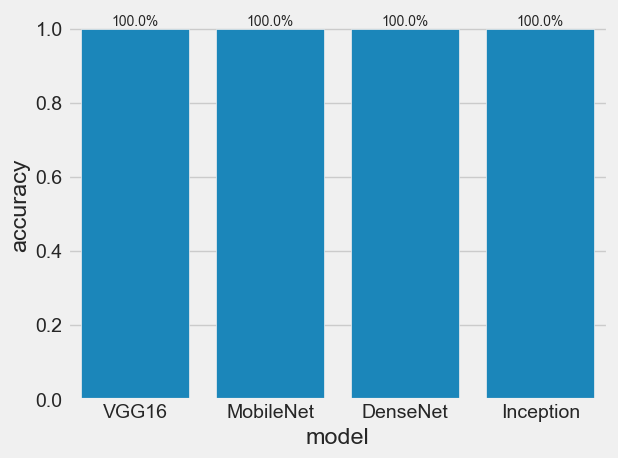

In [48]:
# Create bar chart
sns.barplot(x='model', y='accuracy', data=df)

# Add labels to bars
ax = plt.gca()
for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f"{x:.1%}" for x in bar.datavalues], fontsize=10)

# Adjust the layout
plt.tight_layout()

plt.show()

In [53]:
# Fine-tune the model with frozen layers

# Unfreeze the base_model
no_base_layers = len(model_DenseNet.layers)
print('No. of base layers in the model = {}\n'.format(no_base_layers))

# no of layers for fine-tune
no_finetune_layers = int(no_base_layers/2)
print('No. of layers for fine-tune = {}'.format(no_finetune_layers))

No. of base layers in the model = 7

No. of layers for fine-tune = 3


In [54]:
for layer in model_DenseNet.layers:
    print("Layer Name:", layer.name)
    print("Layer Type:", type(layer).__name__)
    print("Input Shape:", layer.input_shape)
    print("Output Shape:", layer.output_shape)
    print("Trainable:", layer.trainable)
    print("===================")

Layer Name: densenet121
Layer Type: Functional
Input Shape: (None, 299, 299, 3)
Output Shape: (None, 9, 9, 1024)
Trainable: False
Layer Name: global_average_pooling2d_3
Layer Type: GlobalAveragePooling2D
Input Shape: (None, 9, 9, 1024)
Output Shape: (None, 1024)
Trainable: False
Layer Name: dense_11
Layer Type: Dense
Input Shape: (None, 1024)
Output Shape: (None, 128)
Trainable: False
Layer Name: dropout_7
Layer Type: Dropout
Input Shape: (None, 128)
Output Shape: (None, 128)
Trainable: False
Layer Name: dense_12
Layer Type: Dense
Input Shape: (None, 128)
Output Shape: (None, 64)
Trainable: True
Layer Name: dropout_8
Layer Type: Dropout
Input Shape: (None, 64)
Output Shape: (None, 64)
Trainable: True
Layer Name: dense_13
Layer Type: Dense
Input Shape: (None, 64)
Output Shape: (None, 2)
Trainable: True


In [55]:
# Fine-tune the model
model_DenseNet.trainable = True
for layer in model_DenseNet.layers[: -no_finetune_layers]:
    layer.trainable = False

# small learning rate for fine tuning
model_DenseNet.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune_MobileNet = model_DenseNet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping])

Epoch 1/2
222/222 [==============================] - 788s 4s/step - loss: 1.1189e-04 - accuracy: 1.0000 - val_loss: 8.0762e-07 - val_accuracy: 1.0000
Epoch 2/2
222/222 [==============================] - 779s 4s/step - loss: 1.1768e-04 - accuracy: 1.0000 - val_loss: 7.1563e-07 - val_accuracy: 1.0000


In [56]:
# Validate the model
print('====== Model Validation ======')
val_loss_finetune_DenseNet, val_accuracy_finetune_DenseNet = model_DenseNet.evaluate(test_generator, steps=len(test_generator))
print(f'Validation Loss: {val_loss_finetune_DenseNet:.4f}')
print(f'Validation Accuracy: {val_accuracy_finetune_DenseNet:.4f}')

====== Model Validation ======
13/13 [==============================] - 42s 3s/step - loss: 7.1563e-07 - accuracy: 1.0000
Validation Loss: 0.0000
Validation Accuracy: 1.0000


In [57]:
DenseNet_test_preds = model_DenseNet.predict(test_generator)
DenseNet_test_pred_classes = np.argmax(DenseNet_test_preds, axis=1)

13/13 [==============================] - 48s 4s/step


2/2 [==============================] - 7s 1s/step


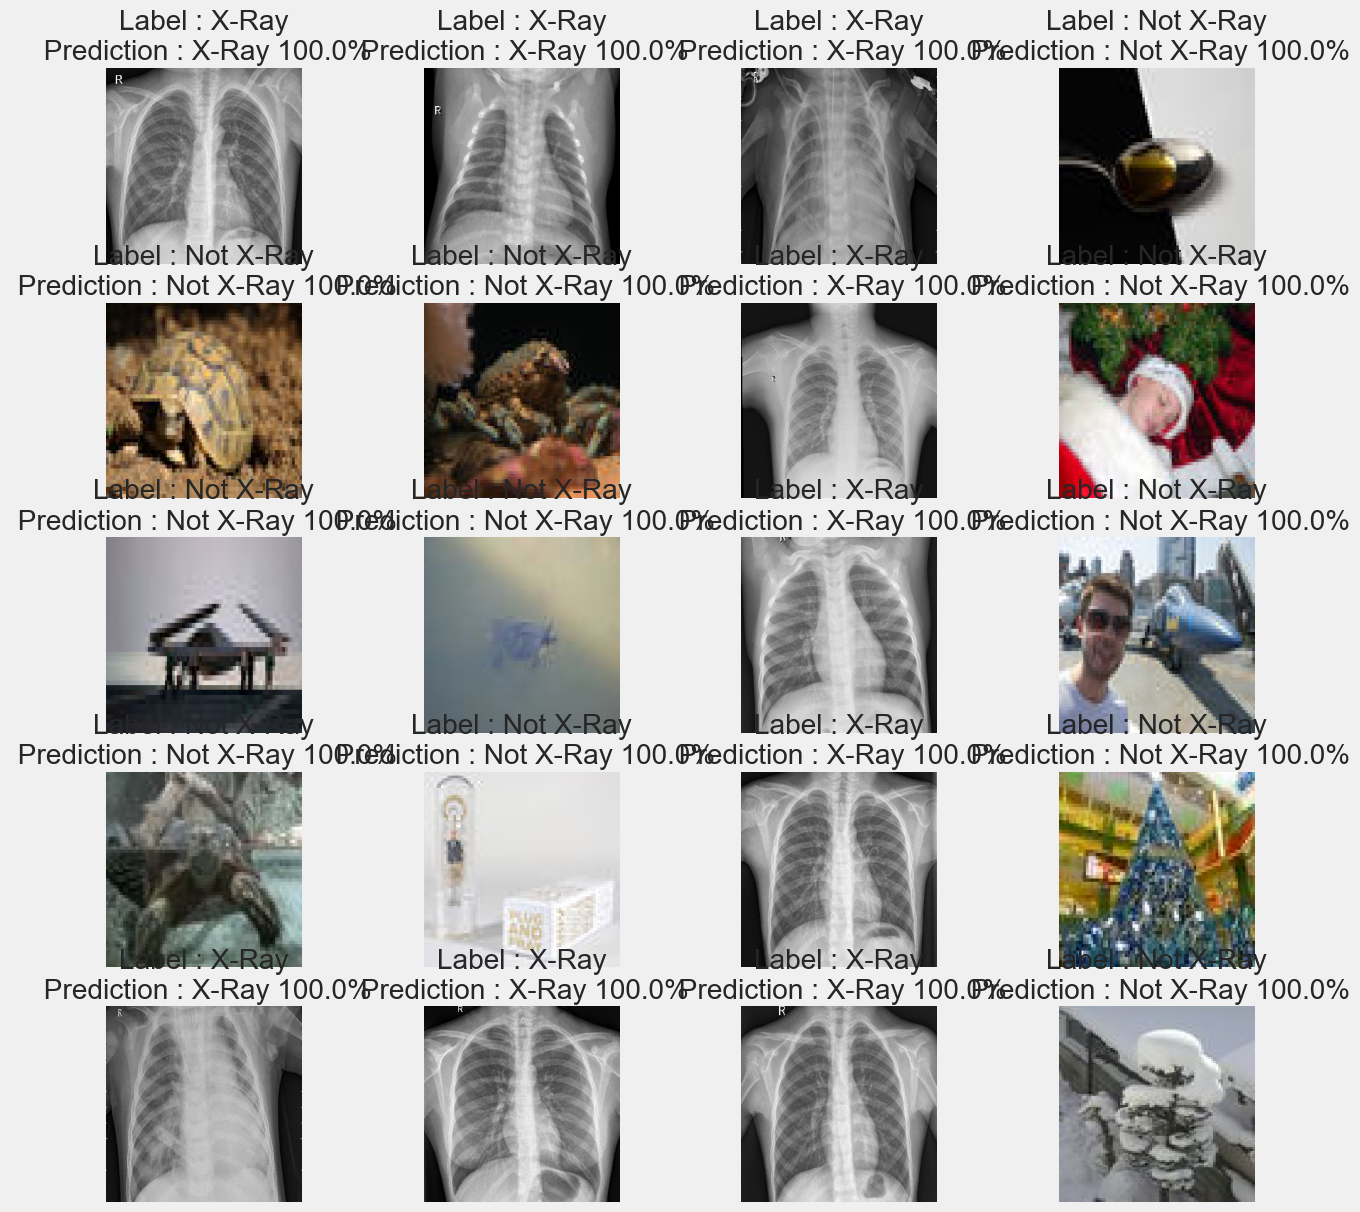

In [58]:
test_generator.reset()
img, label = next(test_generator)

prediction = model_DenseNet.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[14, 14])
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

In [61]:
test_dir = r"C:\Users\PC\OneDrive\Desktop\pneumonia_detection\xray or not\XRAY OR NOT\test"

# Image dimensions
image_height = 299
image_width = 299

# Create ImageDataGenerator for test data
test_data_generator = ImageDataGenerator(rescale=1./255)

# Load test data using the generator
test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=1,
    shuffle=False,  # Important: Set shuffle to False to maintain order
    class_mode='categorical'
)

# Get predictions and true labels
y_pred = model_DenseNet.predict(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
file_names = test_generator.filenames

# Identify mispredicted indices
misclassified_indices = np.where(y_pred_classes != y_true)[0]

# Print file names of mispredicted images
print("\nMispredicted File Names:")
for idx in misclassified_indices:
    print(file_names[idx])

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Classification Report
class_names = list(test_generator.class_indices.keys())
class_report = classification_report(y_true, y_pred_classes, target_names=class_names)

# Display Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

# Display Classification Report
print("\nClassification Report:")
print(class_report)

Found 600 images belonging to 2 classes.
600/600 [==============================] - 53s 88ms/step

Mispredicted File Names:
Confusion Matrix:
[[300   0]
 [  0 300]]

Classification Report:
              precision    recall  f1-score   support

   Not X-Ray       1.00      1.00      1.00       300
       X-Ray       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



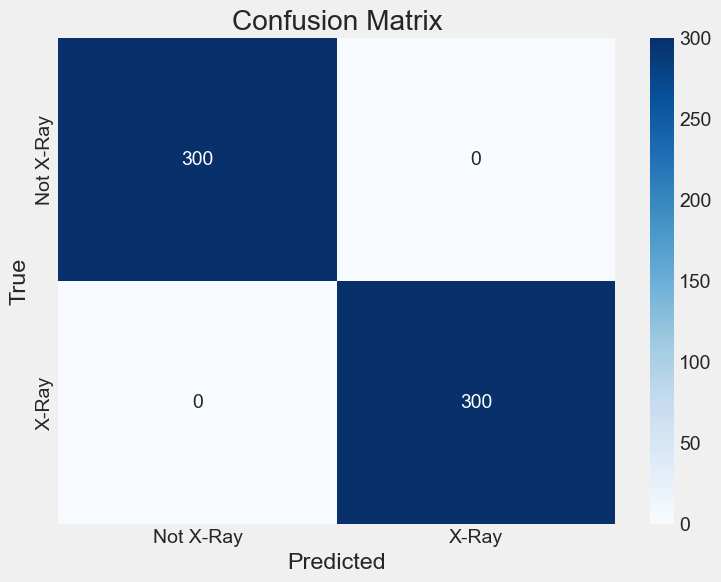

Classification Report:
              precision    recall  f1-score   support

   Not X-Ray       1.00      1.00      1.00       300
       X-Ray       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [62]:
# Visualization of Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print Classification Report
print('Classification Report:')
print(class_report)

In [63]:
model_MobileNet.save("X-Ray-model.h5")
model_MobileNet.save_weights("X-Ray-weights.h5")

C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
